In [1]:
# https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html
# https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html
# https://github.com/marcinjastrzebski8/QuantumKernelEstimation  (useful as a small guide)
# https://xavierbourretsicotte.github.io/SVM_implementation.html
# https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf  ===> how to use cvxopt

# TODO : see if one can improve accuracy
# TODO : graphics to draw the separation hyperplane and see if it has the margins promised in the paper
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer, transpile, Aer, IBMQ
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from cvxopt import matrix, solvers
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, read_csv
import os

seed = 12345
algorithm_globals.random_seed = seed
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size'] = 12

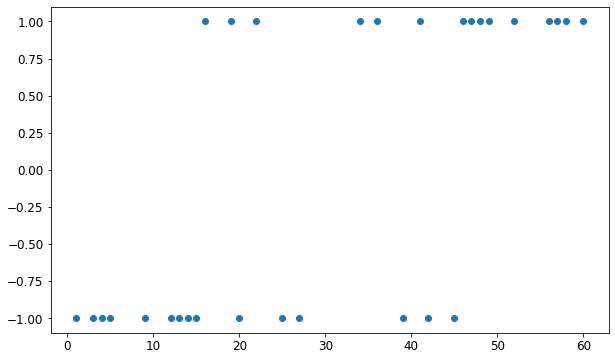

In [23]:
# Creating a dataset

num_features = 6
#df = read_csv("dataset_p_173_g_5_s_40.csv")
df = read_csv("dataset_p_61_g_5_s_15.csv")
num_samples_train = int(0.75 * len(df))
num_samples_test = len(df) - num_samples_train

all_features = list(df['x'])
all_features_bin = [[int(r) for r in (list(format(all_features[idx], '06b')))] for idx in range(len(df))]
#print(all_features_bin)

features_train = all_features_bin[:num_samples_train]
features_test = all_features_bin[num_samples_train:]
#print(features_train)
#print(features_test)

labels = np.array(df['y'])
labels_train = labels[:num_samples_train]
labels_test = labels[num_samples_train:]
#print(labels_train)
#print(labels_test)

plt.plot(all_features, labels, 'o')
plt.show()

In [25]:
### Custom Feature Map

# for now, we have as many qubits as features
num_qubits = num_features
      
# creating the feature map and extracting the kernel matrix
backend = QuantumInstance(Aer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed)

for gate1 in ['X','Y', 'Z']:
    #for gate2 in ['X', 'Y', 'Z']:
    #    for gate3 in ['X', 'Y', 'Z']:

    paulis = [gate1, 'ZY', 'XZY']#, gate2+gate3]
    print(paulis)

    paulis_string = "_".join(paulis)
    foldername = "./all_results_for_DLP_ds_" + paulis_string + "/"
    os.mkdir(foldername)

    fm = PauliFeatureMap(num_qubits, reps=1, paulis=paulis)
    qk = QuantumKernel(feature_map=fm, quantum_instance=backend)
    K = qk.evaluate(features_train)

    numerical_results_filename = foldername + 'accuracy_results.txt'

    lambda_best_acc = -1
    best_acc = -1
    # Computing the alphas of the SVM algorithm
    for lambda_svm in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        Q = np.zeros((num_samples_train, num_samples_train))
        for i in range(num_samples_train):
            for j in range(num_samples_train):
                Q[i][j] = labels[i] * labels[j] * K[i][j]
        Pm = np.eye(num_samples_train) / lambda_svm + Q

        P = matrix(Pm, tc='d')
        q = matrix(-np.ones(num_samples_train), tc='d')
        G = matrix(-np.eye(num_samples_train), tc='d')
        h = matrix(np.zeros(num_samples_train), tc='d')

        sol = solvers.qp(P,q,G,h)
        alpha = (np.array(sol['x']).T)[0]
        good = 0
        bad = 0
        for test_idx in range(num_samples_test):
            new_sum = 0

            for train_idx in range(num_samples_train):
                pair = np.zeros((2, num_features))
                pair[0] = features_train[train_idx]
                pair[1] = features_test[test_idx]
                current_K = qk.evaluate(pair)
                new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)

            if int(new_sum/abs(new_sum)) == int(labels_test[test_idx]):
                good = good + 1
            #    print("Good for " + str(test_idx))
            else:
                bad = bad + 1
            #    print("Bad for " + str(test_idx))

            if round(good / (good + bad), 4) * 100 > best_acc:
                best_acc = round(good / (good + bad), 4) * 100
                lambda_best_acc = lambda_svm

        with open(numerical_results_filename, 'a') as f:
            print("Lambda is: ", lambda_svm, file=f)
            print("Well classifed: ", good, file=f)
            print("Bad classified: ", bad, file=f)
            print("Accuracy: ", round(good / (good + bad), 4) * 100, file=f)
            print('\n################################\n', file=f)

    """
    # Plot for best lambda
    lambda_svm = lambda_best_acc # we plot for the best lambda
    Q = np.zeros((num_samples_train, num_samples_train))
    for i in range(num_samples_train):
        for j in range(num_samples_train):
            Q[i][j] = labels[i] * labels[j] * K[i][j]
    Pm = np.eye(num_samples_train) / lambda_svm + Q

    P = matrix(Pm, tc='d')
    q = matrix(-np.ones(num_samples_train), tc='d')
    G = matrix(-np.eye(num_samples_train), tc='d')
    h = matrix(np.zeros(num_samples_train), tc='d')

    sol = solvers.qp(P,q,G,h)
    alpha = (np.array(sol['x']).T)[0]
    print(alpha[0:4])
    good = 0
    bad = 0

    w_0 = 0
    w_1 = 0
    w_2 = 0
    w_3 = 0

    for test_idx in range(num_samples_test):
        new_sum = 0

        for train_idx in range(num_samples_train):
            pair = np.zeros((2, num_features))
            pair[0] = features_train[train_idx]
            pair[1] = features_test[test_idx]
            current_K = qk.evaluate(pair)
            new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)
            w_0 = w_0 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][0]
            w_1 = w_1 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][1]
            w_2 = w_2 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][2]
            w_3 = w_3 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][3]

    ##

    fig, ax = plt.subplots()

    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='feature 1', y='feature 2', label=key, color=colors[key])

    x0_sample = np.linspace(-10.0, 10.0, num=1000)
    x1_sample = -w_0 * x0_sample / w_1
    ax.plot(x0_sample, x1_sample)

    plt.savefig(foldername + 'pauli_fm_hyperplane_f1_f2.png')
    plt.show()

    ##

    fig, ax = plt.subplots()

    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='feature 2', y='feature 3', label=key, color=colors[key])

    x0_sample = np.linspace(-10.0, 10.0, num=1000)
    x1_sample = -w_1 * x0_sample / w_2
    ax.plot(x0_sample, x1_sample)

    plt.savefig(foldername + 'pauli_fm_hyperplane_f2_f3.png')
    plt.show()

    ##

    fig, ax = plt.subplots()

    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='feature 3', y='feature 4', label=key, color=colors[key])

    x0_sample = np.linspace(-10.0, 10.0, num=1000)
    x1_sample = -w_2 * x0_sample / w_3
    ax.plot(x0_sample, x1_sample)

    plt.savefig(foldername + 'pauli_fm_hyperplane_f3_f4.png')
    plt.show()
    """

['X', 'ZY', 'XZY']
     pcost       dcost       gap    pres   dres
 0: -1.0989e-02 -3.2945e-02  2e-02  0e+00  1e+00
 1: -1.0989e-02 -1.1209e-02  2e-04  1e-18  1e-02
 2: -1.0989e-02 -1.0991e-02  2e-06  9e-19  1e-04
 3: -1.0989e-02 -1.0989e-02  2e-08  8e-19  1e-06
 4: -1.0989e-02 -1.0989e-02  2e-10  9e-19  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0891e-01 -3.2463e-01  2e-01  0e+00  1e+00
 1: -1.0892e-01 -1.1110e-01  2e-03  8e-18  1e-02
 2: -1.0892e-01 -1.0894e-01  2e-05  9e-18  1e-04
 3: -1.0892e-01 -1.0892e-01  2e-07  7e-18  1e-06
 4: -1.0892e-01 -1.0892e-01  2e-09  8e-18  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9459e-01 -2.8409e+00  2e+00  0e+00  1e+00
 1: -1.0010e+00 -1.0234e+00  2e-02  7e-17  4e-02
 2: -1.0016e+00 -1.0018e+00  2e-04  1e-16  3e-04
 3: -1.0016e+00 -1.0016e+00  2e-06  6e-17  3e-06
 4: -1.0016e+00 -1.0016e+00  2e-08  8e-17  3e-08
Optimal solution found.
     pcost       dcost       g

In [ ]:
numerical_results_filename = foldername + 'accuracy_results.txt'

lambda_best_acc = -1
best_acc = -1
# Computing the alphas of the SVM algorithm
for lambda_svm in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    Q = np.zeros((num_samples_train, num_samples_train))
    for i in range(num_samples_train):
        for j in range(num_samples_train):
            Q[i][j] = labels[i] * labels[j] * K[i][j]
    Pm = np.eye(num_samples_train) / lambda_svm + Q

    P = matrix(Pm, tc='d')
    q = matrix(-np.ones(num_samples_train), tc='d')
    G = matrix(-np.eye(num_samples_train), tc='d')
    h = matrix(np.zeros(num_samples_train), tc='d')

    sol = solvers.qp(P,q,G,h)
    alpha = (np.array(sol['x']).T)[0]
    good = 0
    bad = 0
    for test_idx in range(num_samples_test):
        new_sum = 0

        for train_idx in range(num_samples_train):
            pair = np.zeros((2, num_features))
            pair[0] = features_train[train_idx]
            pair[1] = features_test[test_idx]
            current_K = qk.evaluate(pair)
            new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)

        if int(new_sum/abs(new_sum)) == int(labels_test[test_idx]):
            good = good + 1
        #    print("Good for " + str(test_idx))
        else:
            bad = bad + 1
        #    print("Bad for " + str(test_idx))
        
        if round(good / (good + bad), 4) * 100 > best_acc:
            best_acc = round(good / (good + bad), 4) * 100
            lambda_best_acc = lambda_svm
    
    with open(numerical_results_filename, 'a') as f:
        print("Lambda is: ", lambda_svm, file=f)
        print("Well classifed: ", good, file=f)
        print("Bad classified: ", bad, file=f)
        print("Accuracy: ", round(good / (good + bad), 4) * 100, file=f)
        print('\n################################\n', file=f)
        
        
    

In [ ]:
# Plot for best lambda
lambda_svm = lambda_best_acc # we plot for the best lambda
Q = np.zeros((num_samples_train, num_samples_train))
for i in range(num_samples_train):
    for j in range(num_samples_train):
        Q[i][j] = labels[i] * labels[j] * K[i][j]
Pm = np.eye(num_samples_train) / lambda_svm + Q

P = matrix(Pm, tc='d')
q = matrix(-np.ones(num_samples_train), tc='d')
G = matrix(-np.eye(num_samples_train), tc='d')
h = matrix(np.zeros(num_samples_train), tc='d')

sol = solvers.qp(P,q,G,h)
alpha = (np.array(sol['x']).T)[0]
print(alpha[0:4])
good = 0
bad = 0

w_0 = 0
w_1 = 0
w_2 = 0
w_3 = 0

for test_idx in range(num_samples_test):
    new_sum = 0

    for train_idx in range(num_samples_train):
        pair = np.zeros((2, num_features))
        pair[0] = features_train[train_idx]
        pair[1] = features_test[test_idx]
        current_K = qk.evaluate(pair)
        new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)
        w_0 = w_0 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][0]
        w_1 = w_1 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][1]
        w_2 = w_2 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][2]
        w_3 = w_3 + alpha[train_idx] * labels_train[train_idx] * features_train[train_idx][3]

##

fig, ax = plt.subplots()

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='feature 1', y='feature 2', label=key, color=colors[key])
    
x0_sample = np.linspace(-10.0, 10.0, num=1000)
x1_sample = -w_0 * x0_sample / w_1
ax.plot(x0_sample, x1_sample)

plt.savefig(foldername + 'pauli_fm_hyperplane_f1_f2.png')
plt.show()

##

fig, ax = plt.subplots()

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='feature 2', y='feature 3', label=key, color=colors[key])

x0_sample = np.linspace(-10.0, 10.0, num=1000)
x1_sample = -w_1 * x0_sample / w_2
ax.plot(x0_sample, x1_sample)

plt.savefig(foldername + 'pauli_fm_hyperplane_f2_f3.png')
plt.show()

##

fig, ax = plt.subplots()

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='feature 3', y='feature 4', label=key, color=colors[key])

x0_sample = np.linspace(-10.0, 10.0, num=1000)
x1_sample = -w_2 * x0_sample / w_3
ax.plot(x0_sample, x1_sample)

plt.savefig(foldername + 'pauli_fm_hyperplane_f3_f4.png')
plt.show()